# Bootstrapping

Today, we are going to be examining two tools that I think border on statistical magic called **bootstrapping** and **k-fold cross-validation**. We have seen bootstrapping before when we introduced sampling methods, so maybe we will start there for today.

Recall the difference between a **population** and a **sample**. The population is all the possible observations out there. For instance if I were an epidemiologist, this might be people in the U.S. or children in Washington state. 


<img width="304" height="232" alt="Image result for population versus sample" src="http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_BiostatisticsBasics/Sampling3.jpg">

But this can also be applied to measurements in the lab as well such as possible voltage values from this battery. There could be an infinite number of measurements, but either way: accessing the actual population is virtually impossible.

<img width="304" height="223" alt="Image result for thermometer gif" src="https://media.giphy.com/media/26FL3uMhARSAvIZZS/giphy.gif">


As a scientist, you only have access to a sample. Part of designing an experiment is choosing how big your sample should be.

But a key problem is: if you change your sample, it could change your sample mean and sample variance significantly. We talked previously about how calculating **p values** is one way of establishing confidence in our measurements. But **bootstrapping** is a fancy statistical way of getting confidence intervals and standard errors just by playing with your sampling.

Let's demonstrate:

Let's say we were in the lab, and we were making a calibration curve, say absorbance against concentration using UV-vis measurements. You generate the following plot:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

In [11]:
y = np.linspace(0, 100, 20)
x_raw = np.linspace(0, 4, 20)
x = x_raw + np.exp(x_raw*0.4*np.random.rand(20)) - 1

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)
y_fit = intercept + np.array([0,5])*slope

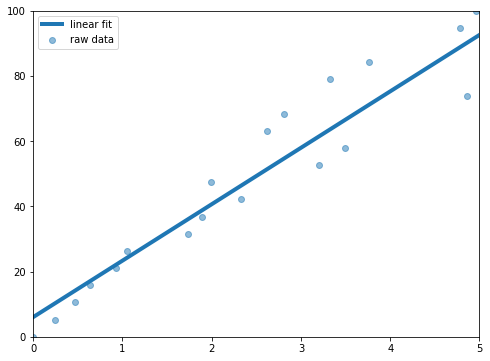

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x, y, alpha=0.5, label='raw data')
ax.plot(np.array([0,5]), y_fit, linewidth=4, label='linear fit')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlim([0, 5])
ax.set_ylim([0, 100])
ax.legend()

But uh oh. You can see that some are those points are a little wiggly. You want to get some indication of how your calibration curve would change if you repeated the experiment again. Instead of actually repeating the experiment, you decide to use bootstrapping.

In bootstrapping, you will resample from you original dataset (pretending its representative of the actual population) with replacement and perform a regression on this sub-sample of your sample. We will generate some code to do this for us. We will take advantage of `pandas` sampling capabilities:

In [13]:
data = pd.DataFrame({'x': x, 'y':y})
data.head()

,x,y
0,0.000000,0.000000
1,0.243773,5.263158
2,0.471281,10.526316
3,0.632171,15.789474
4,0.924983,21.052632


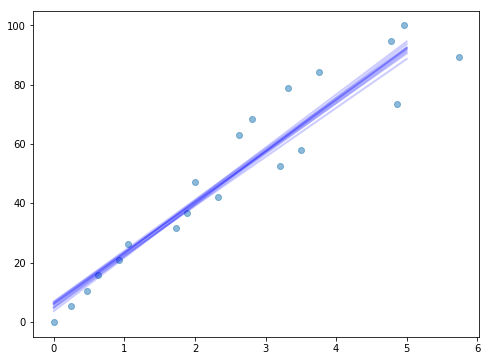

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.5, label='raw data')

# initializing outputs
slope = np.zeros(10)
intercept = np.zeros(10)
rvalue = np.zeros(10)
pvalue = np.zeros(10)
stderr = np.zeros(10)

for i in range(0, 10):
    # Using pandas to grab a random sample WITH replacement
    subsample = data.sample(n=100, replace=True)
    #print(i)
    # Linear regression performed on each sample.
    slope[i], intercept[i], rvalue[i], pvalue[i], stderr[i] = stats.linregress(subsample['x'], subsample['y'])
    y_fit = intercept[i] + np.array([0,5])*slope[i]

    ax.plot(np.array([0,5]), y_fit, linewidth=2, color='b', alpha=0.2)

We can repeat this, like, 1000 times, generate a distribution of slopes and intercepts, and use the distributions to calculate confidence intervals on the slope and intercept:

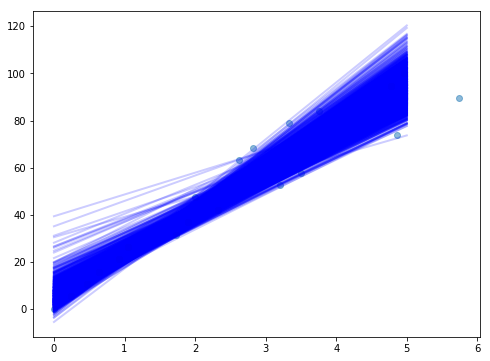

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.5, label='raw data')
n=1000

# initializing outputs
slope = np.zeros(n)
intercept = np.zeros(n)
rvalue = np.zeros(n)
pvalue = np.zeros(n)
stderr = np.zeros(n)

for i in range(0, n):
    # Using pandas to grab a random sample WITH replacement
    subsample = data.sample(n=10, replace=True)
    #print(i)
    # Linear regression performed on each sample.
    slope[i], intercept[i], rvalue[i], pvalue[i], stderr[i] = stats.linregress(subsample['x'], subsample['y'])
    y_fit = intercept[i] + np.array([0,5])*slope[i]

    ax.plot(np.array([0,5]), y_fit, linewidth=2, color='b', alpha=0.2)

In [20]:
print('slope: {:.2f} (95% CI: {:.2f} - {:.2f})'.format(np.mean(slope),
                                                       np.quantile(slope, 0.05),
                                                       np.quantile(slope, 0.95)))

print('intercept: {:.2f} (95% CI: {:.2f} - {:.2f})'.format(np.mean(intercept),
                                                       np.quantile(intercept, 0.05),
                                                       np.quantile(intercept, 0.95)))


slope: 17.56 (95% CI: 14.21 - 21.20)
intercept: 6.06 (95% CI: 0.07 - 14.22)


As a note, this isn't the most useful example, as `stats.linregress` actually calculates SEM values for you. But bootstrapping is generalizable to any statistical quantities you may be interested in. One useful example is error propagation. If you know the error in raw datasets, and you want to know how that error will impact downstream calculations, you can use bootstrapping to do it without having to do the calculus involved in standard error propagation.

Similarly, bootstrapping can be used to estimate error in machine learning methods extending beyond simple linear regression, but we we'll leave it at that so we can move on to other topics.

# Cross-Validation

Cross validation is similar, but, well, different. Cross validation is related to sampling, just like bootstrapping, but is used in slightly different contexts. 

Remember when we talked about the difference between training and test datasets?

<img width="304" height="175" alt="Image result for training test dataset" src="http://scott.fortmann-roe.com/docs/docs/MeasuringError/holdout.png">

When **training** a machine learning model, we split our dataset into a **training dataset** and a **test dataset**. The training dataset is used to train our machine learning model. The test dataset is used to verify the accuracy of our trained model. It is **very** important that the test dataset and training dataset are completely separate, otherwise you could overestimate the accuracy of your model.

We rarely have an indepedent test dataset. In practice, we will randomly split our sample dataset into a training dataset and test dataset. This process is called **validation**. Validation is typically used in two scenarios: **model selection** (proper level of flexibility) and **model assessment** (evaluating a model's performance). We will take a look at both use cases.

`scikit-learn` handily has a function that does this split for us. But first, let's create a datset that we can practice on using a regression model:

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

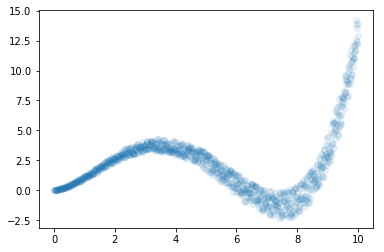

In [23]:
x = np.linspace(0, 10, 1000)
y = 0.2*x + 1*x**2 - 0.3*x**3 + 0.021*x**4 + 0.3*np.random.rand(1000)*x

plt.scatter(x, y, alpha=0.1)

X = pd.DataFrame({'x':x, 'x2':x**2, 'x3':x**3, 'x4':x**4, 'x5':x**5, 'x6':x**6, 'x7':x**7, 'x8':x**8,
                  'x9':x**9, 'x10':x**10, 'x11':x**12, 'x13':x**13, 'x14':x**14, 'x15':x**15, 'x16':x**16, 'x17':x**17})

We'll use validation to select the degree of flexibility of our linear model. First, the split:

In [24]:
X

,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x13,x14,x15,x16,x17
0,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.01001,0.000100,0.000001,1.004010e-08,1.005015e-10,1.006021e-12,1.007028e-14,1.008036e-16,1.009045e-18,1.010055e-20,1.012078e-24,1.013091e-26,1.014106e-28,1.015121e-30,1.016137e-32,1.017154e-34
2,0.02002,0.000401,0.000008,1.606416e-07,3.216048e-09,6.438535e-11,1.288996e-12,2.580572e-14,5.166311e-16,1.034297e-17,4.145473e-21,8.299245e-23,1.661511e-24,3.326347e-26,6.659354e-28,1.333204e-29
3,0.03003,0.000902,0.000027,8.132481e-07,2.442187e-08,7.333893e-10,2.202370e-11,6.613725e-13,1.986104e-14,5.964275e-16,5.378599e-19,1.615195e-20,4.850435e-22,1.456587e-23,4.374136e-25,1.313554e-26
4,0.04004,0.001603,0.000064,2.570266e-06,1.029135e-07,4.120662e-09,1.649915e-10,6.606266e-12,2.645151e-13,1.059120e-14,1.697986e-17,6.798742e-19,2.722219e-20,1.089978e-21,4.364274e-23,1.747457e-24
5,0.05005,0.002505,0.000125,6.275063e-06,3.140672e-07,1.571908e-08,7.867407e-10,3.937641e-11,1.970791e-12,9.863821e-14,2.470894e-16,1.236684e-17,6.189609e-19,3.097902e-20,1.550502e-21,7.760269e-23
6,0.06006,0.003607,0.000217,1.301197e-05,7.814997e-07,4.693692e-08,2.819034e-09,1.693114e-10,1.016885e-11,6.107418e-13,2.203074e-15,1.323168e-16,7.946953e-18,4.772945e-19,2.866634e-20,1.721702e-21
7,0.07007,0.004910,0.000344,2.410628e-05,1.689129e-06,1.183574e-07,8.293309e-09,5.811128e-10,4.071861e-11,2.853156e-12,1.400847e-14,9.815743e-16,6.877898e-17,4.819348e-18,3.376920e-19,2.366211e-20
8,0.08008,0.006413,0.000514,4.112425e-05,3.293233e-06,2.637224e-07,2.111891e-08,1.691204e-09,1.354317e-10,1.084539e-11,6.954950e-14,5.569529e-15,4.460083e-16,3.571638e-17,2.860171e-18,2.290427e-19
9,0.09009,0.008116,0.000731,6.587310e-05,5.934513e-06,5.346408e-07,4.816584e-08,4.339265e-09,3.909248e-10,3.521845e-11,2.858408e-13,2.575143e-14,2.319948e-15,2.090043e-16,1.882922e-17,1.696326e-18


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [26]:
reg = LinearRegression().fit(X_train[['x']], y_train)
y_pred = reg.predict(X_test[['x']])

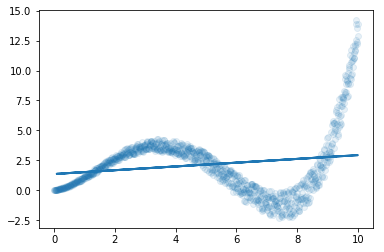

In [27]:
plt.scatter(x, y, alpha=0.1)
plt.plot(X_test[['x']], y_pred, linewidth=2)

We can get a measure of the degree of quality of fit using the mean squared error:

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
mean_squared_error(y_test, y_pred)

7.326641362210417

Now, let's repeat the linear regression while increasing the degree of our polynomial:

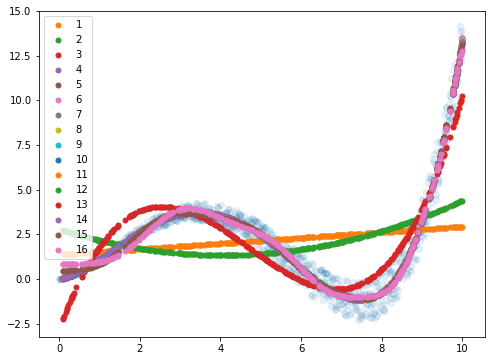

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, alpha=0.1)
mse = np.zeros(17)

for i in range(1, 17):
    reg = LinearRegression().fit(X_train[X_train.columns[0:i].values], y_train)
    y_pred = reg.predict(X_test[X_test.columns[0:i].values])

    ax.scatter(X_test[['x']], y_pred, marker='o', s=25, label=i)
    mse[i-1] = mean_squared_error(y_test, y_pred)
    ax.legend()

Text(0.5,0,'Degree of Polynomial')

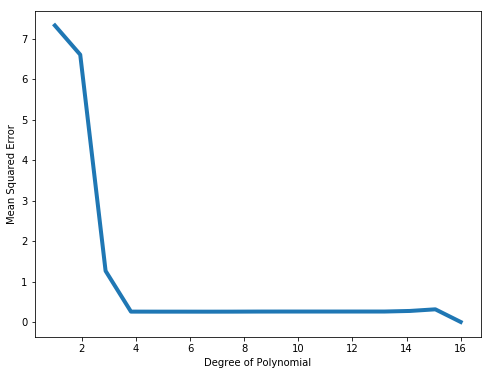

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(1, 16, 17), mse, linewidth=4)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Degree of Polynomial')

From these results, we can see that the MSE reaches a local minimum at a degree of 4. This seems to be the best balance between bias and variance. 

This validation method has two disadvantages:
    
* The test error is highly variable, depending on your training dataset. If we used a different training dataset, we'd have a different error
* We only use a subset of the training dataset to create our model. The fewer the observations, the worse the final model (we actually overestimate the test error rate!)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

for run in range(8):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    mse = np.zeros(17)

    for i in range(1, 18):
        reg = LinearRegression().fit(X_train[X_train.columns[0:i].values], y_train)
        y_pred = reg.predict(X_test[X_test.columns[0:i].values])

        mse[i-1] = mean_squared_error(y_test, y_pred)

    
    ax.plot(np.linspace(1, 16, 17), mse, linewidth=4, color='b', alpha=0.2)
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Degree of Polynomial')

One common alternative to is **K-fold cross-validation**. In this configuration, we split the original dataset into *k* units. In on training-test configuration, *k-1* of the units will be used as a training dataset, while the remaining unit will be used as a test dataset. We train a model *k* times, switching out the test dataset each time, and use the average error as an estimate of the actual test error.

<img width="608" height="334" alt="Image result for k-fold cross-validation" src="https://cdn-images-1.medium.com/max/1600/1*me-aJdjnt3ivwAurYkB7PA.png">

In [32]:
from sklearn.model_selection import KFold

In [33]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X, y)

10

In [41]:
X.iloc[train_index]

,x,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x13,x14,x15,x16,x17
0,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.02002,0.000401,0.000008,1.606416e-07,3.216048e-09,6.438535e-11,1.288996e-12,2.580572e-14,5.166311e-16,1.034297e-17,4.145473e-21,8.299245e-23,1.661511e-24,3.326347e-26,6.659354e-28,1.333204e-29
3,0.03003,0.000902,0.000027,8.132481e-07,2.442187e-08,7.333893e-10,2.202370e-11,6.613725e-13,1.986104e-14,5.964275e-16,5.378599e-19,1.615195e-20,4.850435e-22,1.456587e-23,4.374136e-25,1.313554e-26
4,0.04004,0.001603,0.000064,2.570266e-06,1.029135e-07,4.120662e-09,1.649915e-10,6.606266e-12,2.645151e-13,1.059120e-14,1.697986e-17,6.798742e-19,2.722219e-20,1.089978e-21,4.364274e-23,1.747457e-24
5,0.05005,0.002505,0.000125,6.275063e-06,3.140672e-07,1.571908e-08,7.867407e-10,3.937641e-11,1.970791e-12,9.863821e-14,2.470894e-16,1.236684e-17,6.189609e-19,3.097902e-20,1.550502e-21,7.760269e-23
6,0.06006,0.003607,0.000217,1.301197e-05,7.814997e-07,4.693692e-08,2.819034e-09,1.693114e-10,1.016885e-11,6.107418e-13,2.203074e-15,1.323168e-16,7.946953e-18,4.772945e-19,2.866634e-20,1.721702e-21
7,0.07007,0.004910,0.000344,2.410628e-05,1.689129e-06,1.183574e-07,8.293309e-09,5.811128e-10,4.071861e-11,2.853156e-12,1.400847e-14,9.815743e-16,6.877898e-17,4.819348e-18,3.376920e-19,2.366211e-20
8,0.08008,0.006413,0.000514,4.112425e-05,3.293233e-06,2.637224e-07,2.111891e-08,1.691204e-09,1.354317e-10,1.084539e-11,6.954950e-14,5.569529e-15,4.460083e-16,3.571638e-17,2.860171e-18,2.290427e-19
9,0.09009,0.008116,0.000731,6.587310e-05,5.934513e-06,5.346408e-07,4.816584e-08,4.339265e-09,3.909248e-10,3.521845e-11,2.858408e-13,2.575143e-14,2.319948e-15,2.090043e-16,1.882922e-17,1.696326e-18
10,0.10010,0.010020,0.001003,1.004010e-04,1.005015e-05,1.006021e-06,1.007028e-07,1.008036e-08,1.009045e-09,1.010055e-10,1.012078e-12,1.013091e-13,1.014106e-14,1.015121e-15,1.016137e-16,1.017154e-17


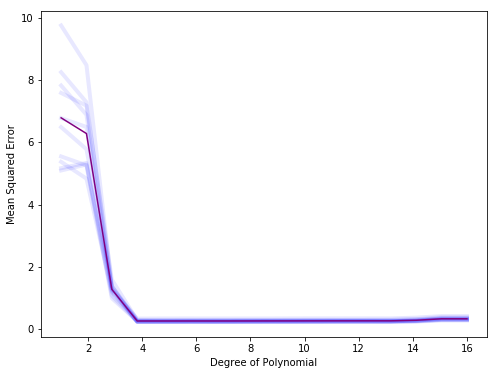

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

mse = np.zeros((17, 10))
j = 0
for train_index, test_index in kf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for i in range(1, 18):
        reg = LinearRegression().fit(X_train[X_train.columns[0:i].values], y_train)
        y_pred = reg.predict(X_test[X_test.columns[0:i].values])

        mse[i-1, j] = mean_squared_error(y_test, y_pred)

    
    ax.plot(np.linspace(1, 16, 17), mse[:, j], linewidth=4, color='b', alpha=0.09)
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Degree of Polynomial')
    j += 1
    
avg_mse = mse.mean(axis=1)
ax.plot(np.linspace(1, 16, 17), avg_mse, color='purple')

In [ ]:
avg_mse